<a href="https://colab.research.google.com/github/BKousha/FloorPlanSegmentation/blob/main/inference_using_pytorch_trained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lmdb
!pip install svgpathtools
!pip install matplotlib==3.5

import os
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive"
#!ls "/content/drive/My Drive/Processed Floor Plans"



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'
'Copy of Predictive Maintenance Checklist.gdoc'
 FloorPlan_samples
 model_best_val_loss_var.pkl
 Processed_Floor_Plans
'SNN_soft shadow network for image compositing.pdf'
 test.txt


In [ ]:
! rm -rf /content/CubiCasa5k
! git clone -b BK_inference https://github.com/BKousha/CubiCasa5k.git

#!gdown https://drive.google.com/u/0/uc?id=1gRB7ez1e4H7a9Y09lLqRuna0luZO5VRK&export=download
#!cp model_best_val_loss_var.pkl /content/drive/MyDrive  # keep backup of the model

Cloning into 'CubiCasa5k'...
remote: Enumerating objects: 189, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 189 (delta 45), reused 44 (delta 24), pack-reused 120
Receiving objects: 100% (189/189), 62.50 MiB | 24.81 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [ ]:
%matplotlib inline
import matplotlib

print("Matplotlib version:", matplotlib.__version__)
from skimage import transform
import numpy as np
import cv2
import svgwrite


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
sys.path.insert(1, '/content/CubiCasa5k')

import matplotlib.cm as cm
if 'rooms_furu' in cm.cmap_d:
    cm.unregister_cmap('rooms_furu')


from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid
torch.manual_seed(0)


Matplotlib version: 3.5.0


/content/CubiCasa5k/floortrans/loaders/svg_utils.py:565: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if direction is 'H':
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4
/content/CubiCasa5k/floortrans/loaders/svg_utils.py:637: SyntaxWarning: "is" with a literal. Did you mean "=="?
  assert len(X) is 4 and len(Y) is 4
/content/CubiCasa5k/floortrans/plotting.py:611: UserWarning: Trying to register the cmap 'rooms_furu' which already exists.
  cm.register_cmap(cmap=cmap3)


In [ ]:
# import os
# directory = '/content/drive/MyDrive/Processed_Floor_Plans/FP_raw'  # Specify the directory path

# # Get a list of files in the directory
# file_list = [os.path.join(directory, file) for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file)) and file.lower().endswith('.png')]

# print(file_list)
# # Save the list as a text file
# output_file = '/content/drive/MyDrive/test.txt'  # Specify the output file name
# import pandas as pd
# df=pd.DataFrame({'input':file_list})
# df.to_csv(output_file,index=False)

In [ ]:
data_folder = ''
data_file = '/content/drive/MyDrive/test.txt'
normal_set = FloorplanSVG(data_folder, data_file,scale_image=0.5)
print(normal_set.__len__())
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
val = next(data_iter)


Index(['input'], dtype='object')
300
/content/drive/MyDrive/Processed_Floor_Plans/FP_raw/41.png


In [ ]:

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

# Setup Model
model = get_model('/content/CubiCasa5k/','hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)

checkpoint = torch.load('/content/drive/MyDrive/model_best_val_loss_var.pkl',map_location=torch.device('cpu'))


model.load_state_dict(checkpoint['model_state'])
model.eval()
#model.cuda()
print("Model loaded.")

/content/CubiCasa5k/floortrans/models/model_1427.pth
Model loaded.


/content/drive/MyDrive/Processed_Floor_Plans/FP_raw/42.png
(1537, 2463, 3)


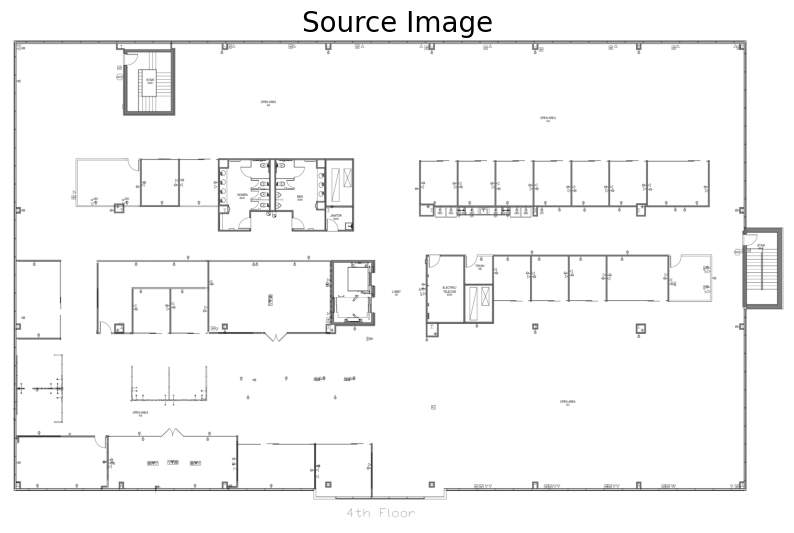

In [ ]:
val = next(data_iter)
#junctions = val['heatmaps']
filename = val['file'][0]
image = val['image']#.cuda()
#label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
print(np_img.shape)
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

In [ ]:
n_classes = 44
n_rooms = 12
n_icons = 11
# with torch.no_grad():
#     height = np_img.shape[0]
#     width = np_img.shape[1]
#     img_size = (height, width)
#     prediction = torch.zeros([1, n_classes, height, width])
#     pred = model(image)
#     pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)


In [ ]:
# plt.figure(figsize=(10,10))
# plt.title('Source Image', fontsize=20)
# plt.axis('off')
# plt.imshow(np_img)
# plt.show()

In [ ]:
type(image)

torch.Tensor

0
1
2
3


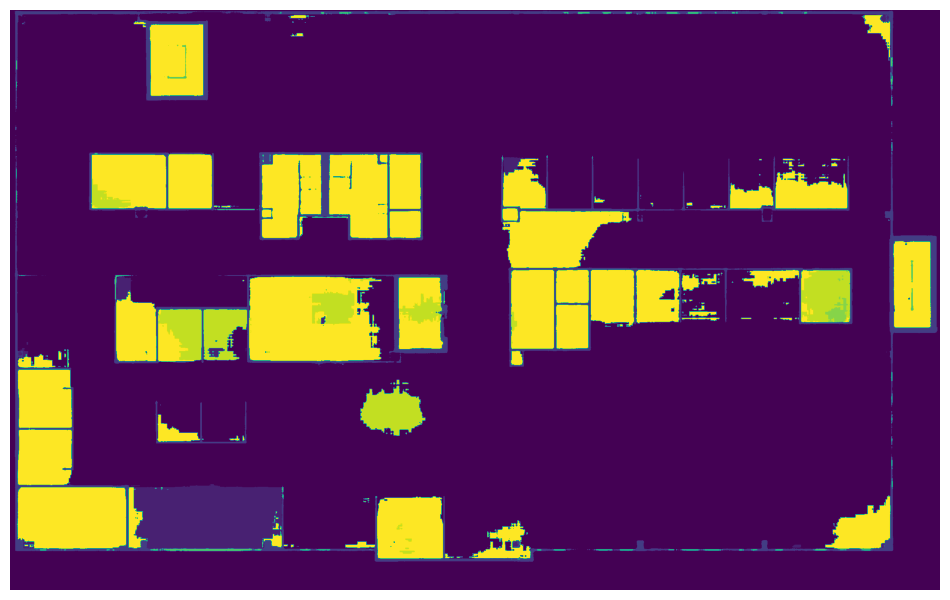

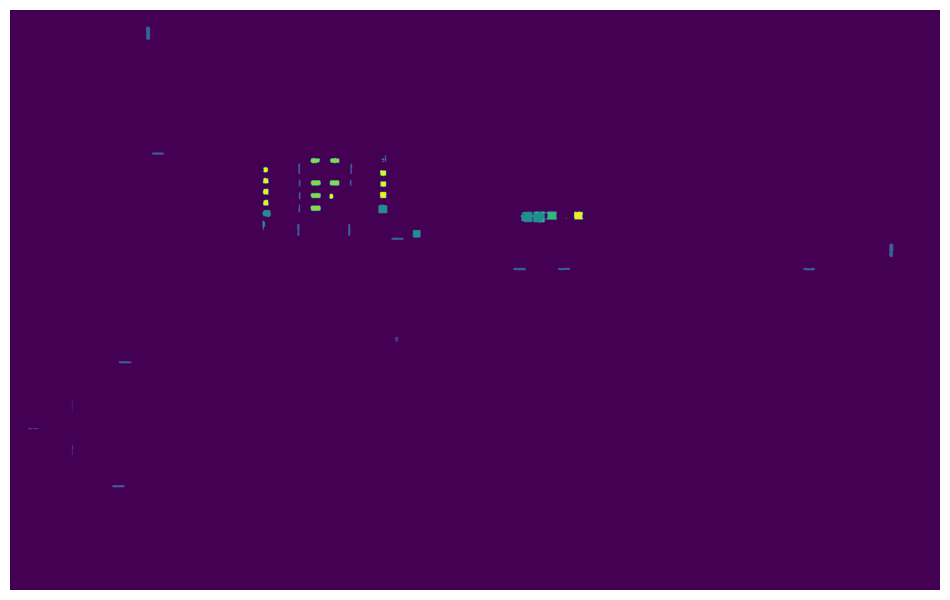

In [ ]:
with torch.no_grad():
    height = np_img.shape[0]
    width = np_img.shape[1]
    img_size = (height, width)

    rotations = [(0, 0), (1, -1), (2, 2), (-1, 1)]
    pred_count = len(rotations)
    prediction = torch.zeros([pred_count, n_classes, height, width])
    for i, r in enumerate(rotations):
        print(i)
        forward, back = r
        # We rotate first the image
        rot_image = rot(image, 'tensor', forward)
        pred = model(rot_image)
        # We rotate prediction back
        pred = rot(pred, 'tensor', back)
        # We fix heatmaps
        pred = rot(pred, 'points', back)
        # We make sure the size is correct
        pred = F.interpolate(pred, size=(height, width), mode='bilinear', align_corners=True)
        # We add the prediction to output
        prediction[i] = pred[0]

prediction = torch.mean(prediction, 0, True)
#rooms_label = label_np[0]
#icons_label = label_np[1]

rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
ax.imshow(rooms_pred)
#cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
ax.imshow(icons_pred)#, cmap='icons', vmin=0, vmax=n_icons-0.1
plt.show()
#cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(icon_classes, fontsize=20)

/content/CubiCasa5k/floortrans/post_prosessing.py:909: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  wall_width = stats.mode(widths).mode[0]
/content/CubiCasa5k/floortrans/post_prosessing.py:965: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  wall_width = stats.mod

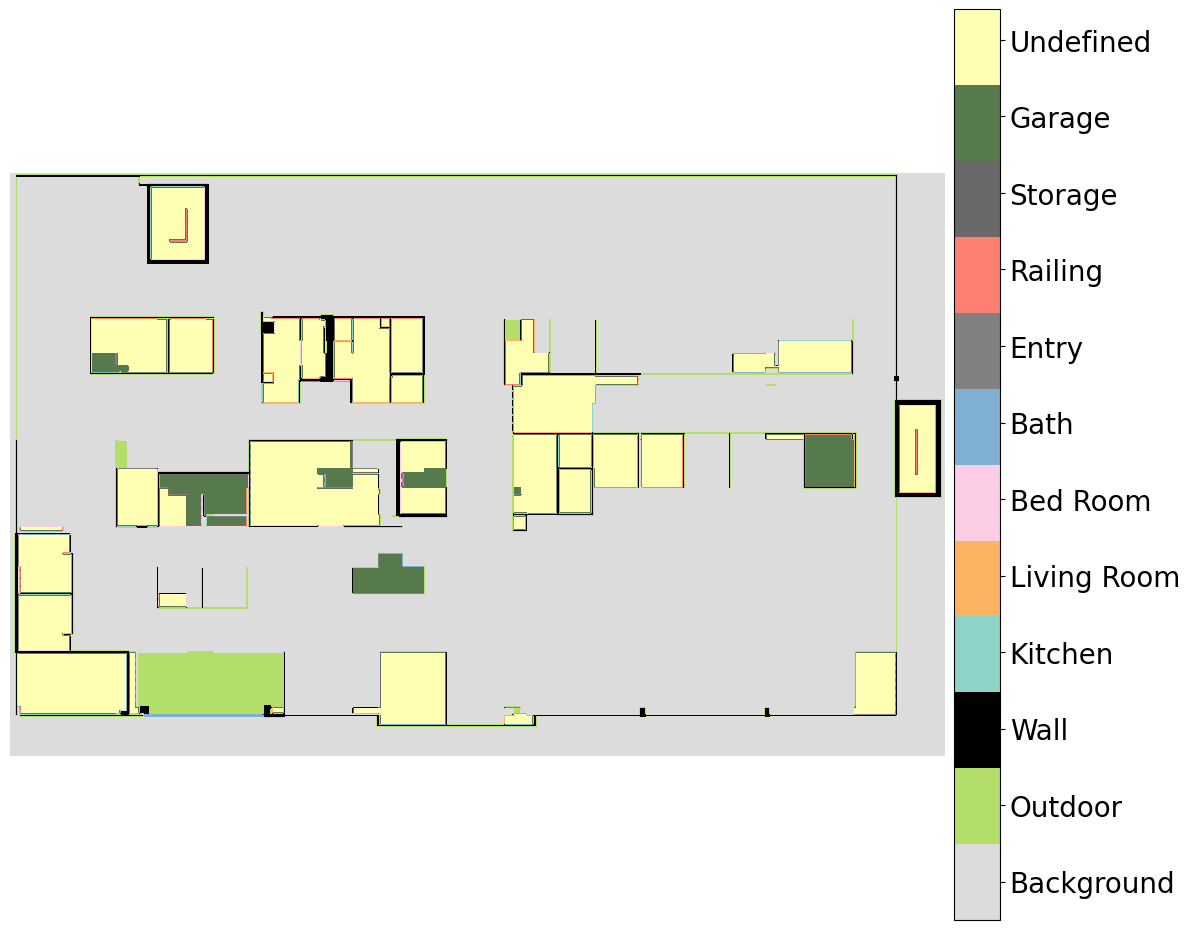

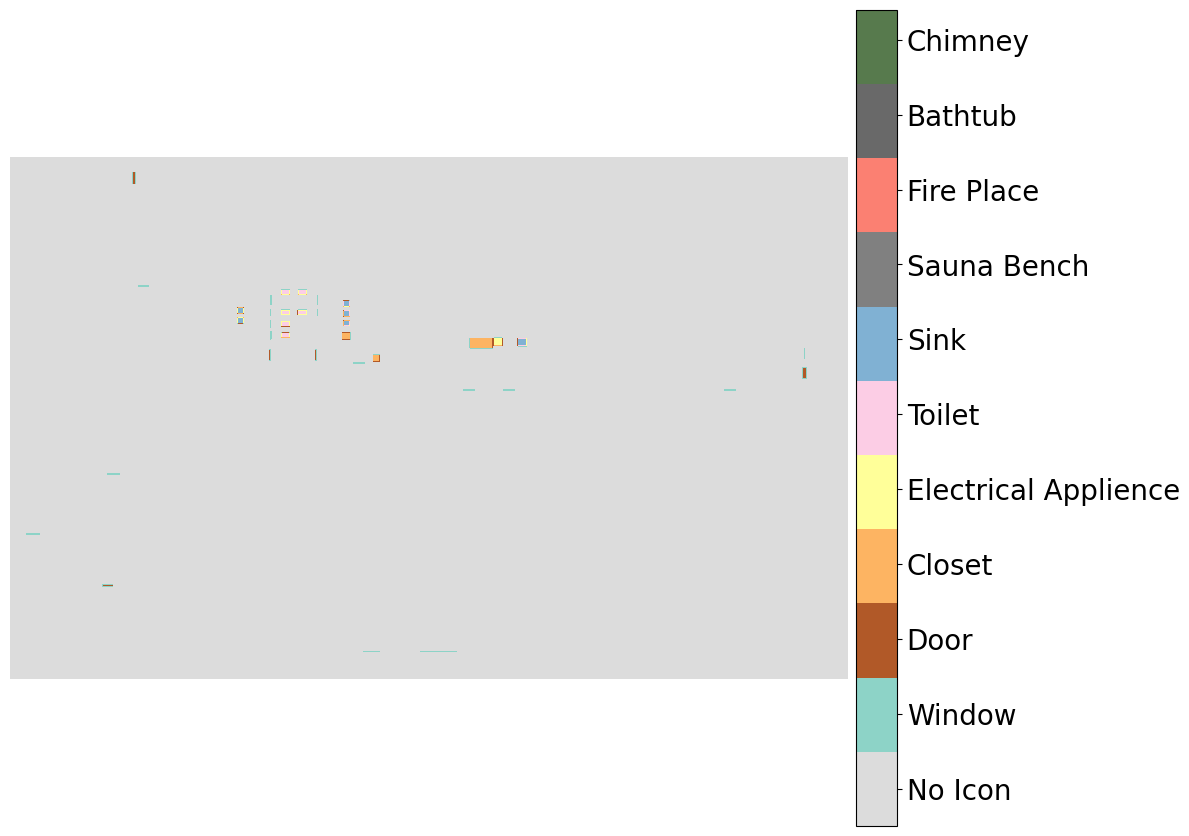

In [ ]:
heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, height, width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4


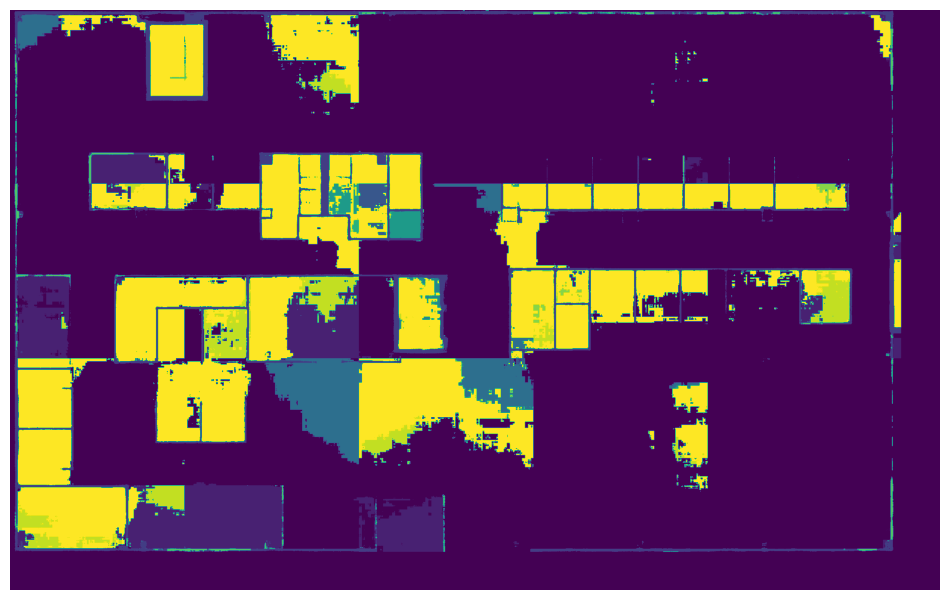

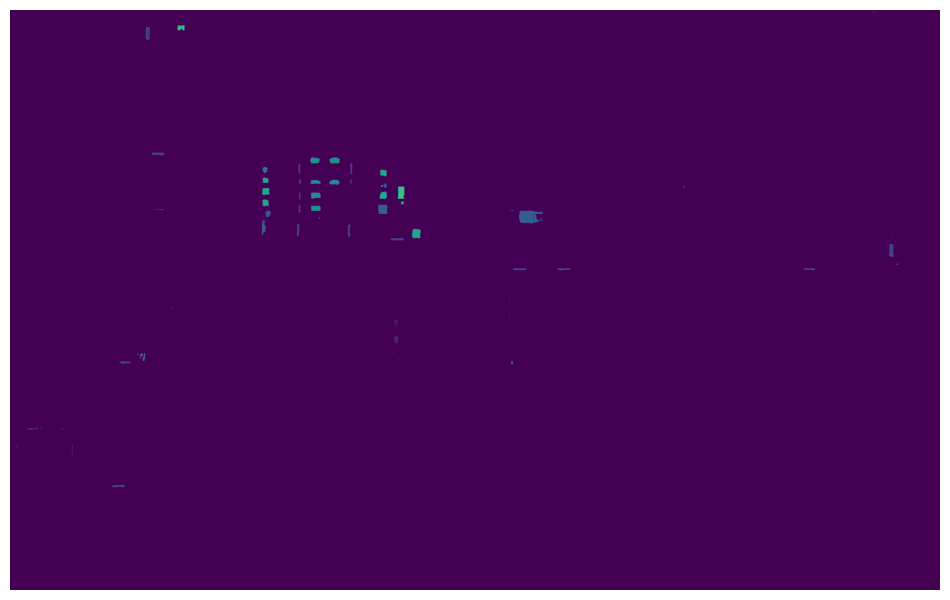

In [ ]:
piece_size = (512, 512)
overlap = 50  # Adjust this value as needed

# Load the large input image as a Torch tensor
input_tensor = image

# Get the dimensions of the input tensor
input_height, input_width = input_tensor.shape[-2:]


# Create an output tensor for storing the stitched result
output_tensor = torch.zeros((1, 44, input_height, input_width))
with torch.no_grad():
  for k, y in enumerate(range(0, input_height - piece_size[0], piece_size[0] - overlap)):
    for j, x in enumerate(range(0, input_width - piece_size[1], piece_size[1] - overlap)):
          print(k,j)
          # Extract the smaller piece from the input tensor
          piece = input_tensor[..., y:y+piece_size[0], x:x+piece_size[1]]

          # Perform prediction on the smaller piece using your model
          prediction = model(piece)

          # Stitch the predicted piece back into the output tensor
          output_tensor[..., y:y+piece_size[0], x:x+piece_size[1]] = prediction

prediction = output_tensor
rooms_pred = F.softmax(prediction[0, 21:21+12], 0).cpu().data.numpy()
rooms_pred = np.argmax(rooms_pred, axis=0)

icons_pred = F.softmax(prediction[0, 21+12:], 0).cpu().data.numpy()
icons_pred = np.argmax(icons_pred, axis=0)

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
ax.imshow(rooms_pred)
#cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
ax.imshow(icons_pred)#, cmap='icons', vmin=0, vmax=n_icons-0.1
plt.show()
#cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
#cbar.ax.set_yticklabels(icon_classes, fontsize=20)


/usr/local/lib/python3.10/dist-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


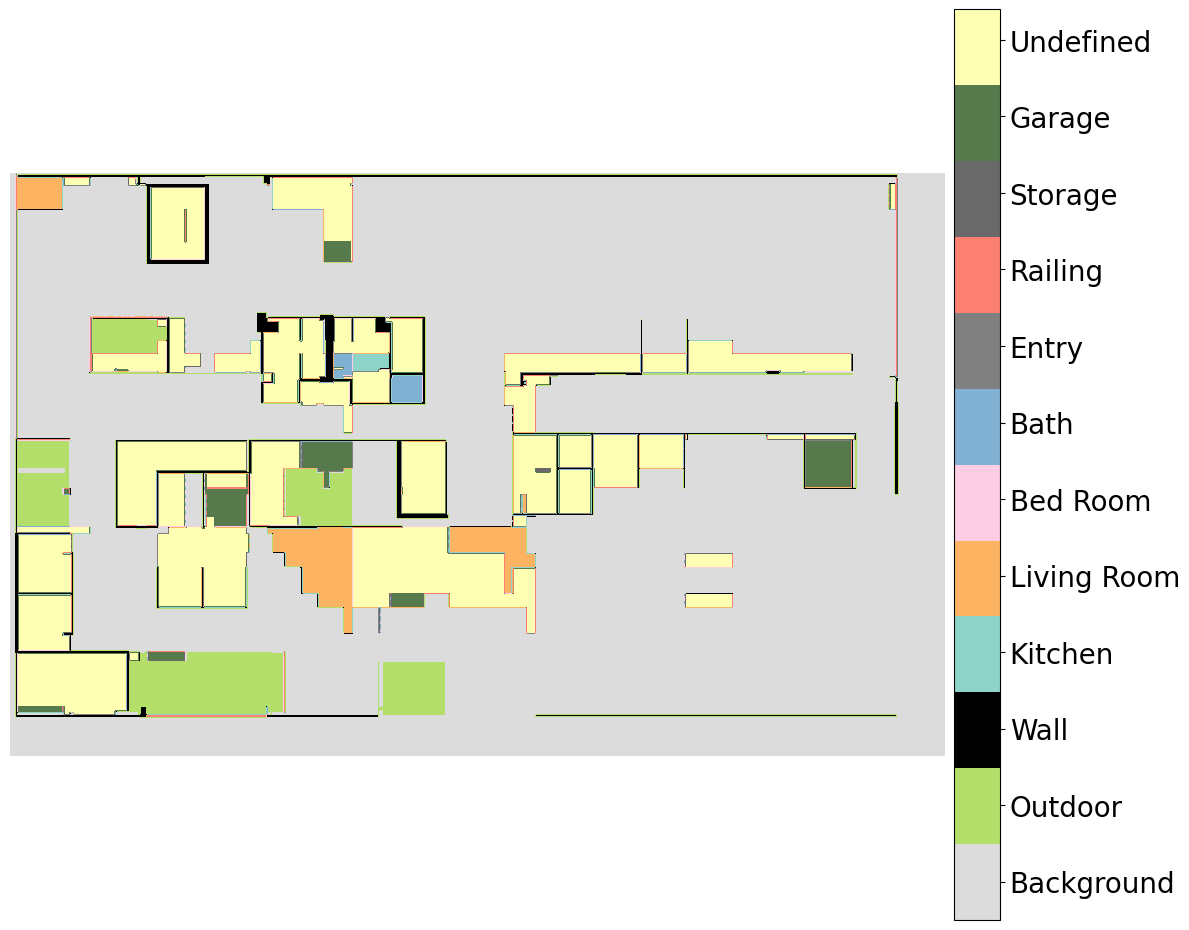

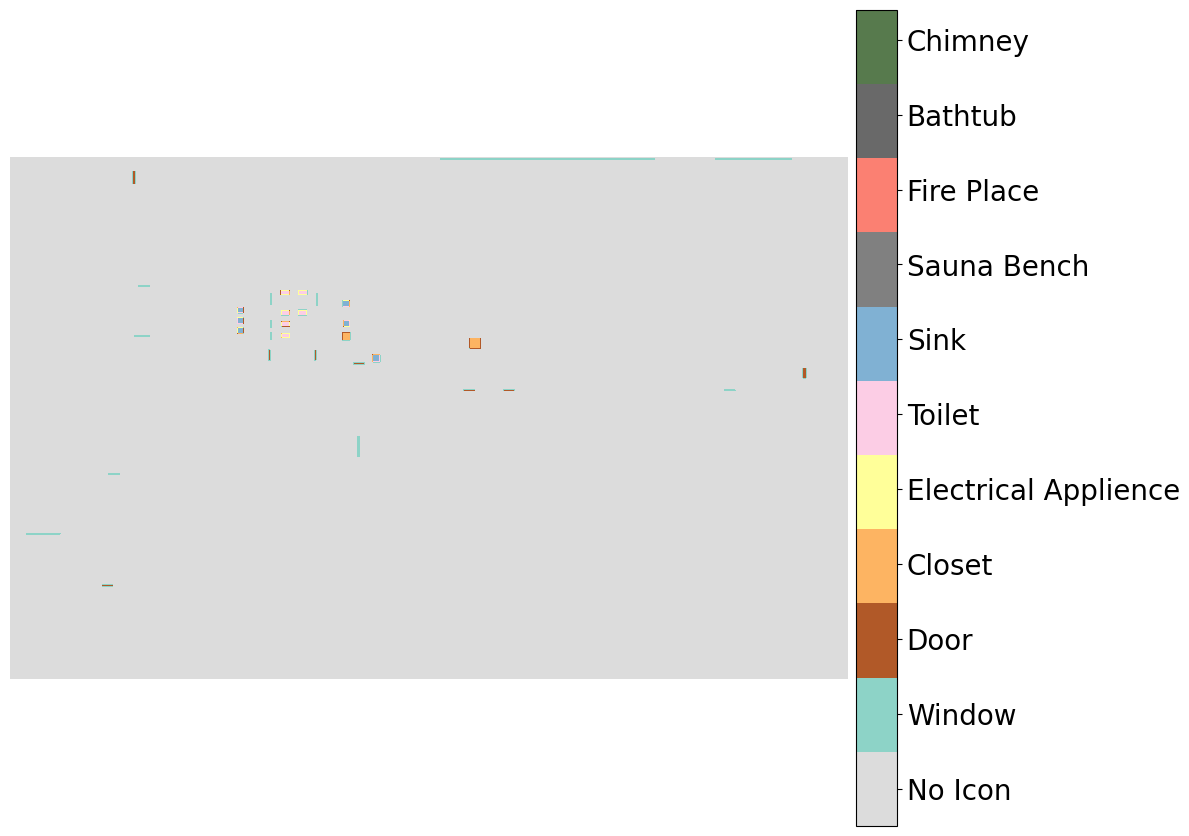

In [ ]:
img_size = (input_height, input_width)

heatmaps, rooms, icons = split_prediction(prediction, img_size, split)
polygons, types, room_polygons, room_types = get_polygons((heatmaps, rooms, icons), 0.2, [1, 2])

pol_room_seg, pol_icon_seg = polygons_to_image(polygons, types, room_polygons, room_types, input_height, input_width)
plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
rseg = ax.imshow(pol_room_seg, cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
ax = plt.subplot(1, 1, 1)
ax.axis('off')
iseg = ax.imshow(pol_icon_seg, cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.tight_layout()
plt.show()